# Twitter Stance Detection  
W266 - NLP  
Alex Dessouky & Tim Spittle

NOTES to myself:
* why is classification report not outputting the micro, macro, weighted avgs?
* we have a class weighting problem
* getting different f1 scores if I call f1 directly vs classification report  
* summary by topic needed to more succinctly show this

## 1 - Load Packages & Data

In [1]:
# Data objects
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
from collections import Counter

# Text Manipulation
import re
import string

# Timing
import time

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn import metrics #f1_score, classification_report, confusion_matrix, roc_auc_score

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [11]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-hub

# # Tensor Flow
# import tensorflow as tf
# import tensorflow_hub as hub
# elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [12]:
#load training data
twitter_train = pd.read_excel('./StanceDataset/train.xlsx')
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [13]:
#load test data
twitter_test = pd.read_excel('./StanceDataset/test.xlsx')
twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


## 2 - Pre-process Data

In [7]:
# Example tweet
tweet_example = twitter_train['Tweet'][0]
print(tweet_example)

@tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot


In [8]:
def preprocess_tweets(x):
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
    x_lower = x_nopunc.lower()
    
    # Replace digits with DIGIT
    x_digits = re.sub("\d+", "DIGIT", x_lower)
    
    return x_digits

In [9]:
preprocess_tweets(tweet_example)

'@tedcruz and #handovertheserver she wiped clean  DIGITk deleted emails explains dereliction of dutylies re #benghazietc #tcot'

## 3 - Models

### Prep Output Functions

In [50]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
# Histograms of predicted probabilities
def class_prob_breakdown(model_results):
    plt.figure(figsize=(20, 10))

    plt.subplot(2,3,1)
    plt.title("Prob. Dist. - Predicted Against")
    plt.hist([item[0] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,2)
    plt.title("Prob. Dist. - Predicted None")
    plt.hist([item[1] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,3)
    plt.title("Prob. Dist. - Predicted Favor")
    plt.hist([item[2] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,4)
    plt.title("Prob. Dist. - Probability Against, by True Label")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")

    plt.subplot(2,3,5)
    plt.title("Prob. Dist. - Probability None, by True Label")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")
    
    plt.subplot(2,3,6)
    plt.title("Prob. Dist. - Probability Against, by True Label")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")

    plt.show()
    
def standard_output(model_results):
    # F1
    f1 = metrics.f1_score(y_true = model_results['test_true_labels'], 
                          y_pred = model_results['test_predict'],
                         average = 'weighted')
    print("F1 Score: " + str(f1))
    # Class Weights
    plt.subplot(1,2,1)
    model_results['train_names'].value_counts().plot(kind='bar', title = "Class Distribution - Train")
    plt.subplot(1,2,2)
    model_results['test_true_names'].value_counts().plot(kind='bar', title = "Class Distribution - Test")
    # Classification Report
    print(metrics.classification_report(y_true = model_results['test_true_labels'], 
                                        y_pred = model_results['test_predict'],
                                        target_names = ['Against', 'None', 'Favor']))
    # Confusion Matrix
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    confusion_plot(confusion_matrix = metrics.confusion_matrix(y_true = model_results['test_true_labels'], 
                                                               y_pred = model_results['test_predict']), 
                   target_names = ['Against', 'None', 'Favor'])
    # Class probability breakdown
    class_prob_breakdown(model_results = model_results)

### Baseline (ZeroR)

In [16]:
def baseline_stance(train, test, topic_in):
    # Subset data to topic being tested
    train_topic = train[train['Target'] == topic_in]
    test_topic = test[test['Target'] == topic_in]
    
    #### TARGET ####
    # Convert stance to labels for feeding sklearn SVM
    train_stance_labels = np.array(train_topic['Stance'].apply(lambda x: 
                                                               2 if x == "FAVOR" else 
                                                               (1 if x == "NONE" else 0)))
    test_stance_labels = np.array(test_topic['Stance'].apply(lambda x: 
                                                             2 if x == "FAVOR" else 
                                                             (1 if x == "NONE" else 0)))
    
    #### MODEL ####
    print(topic_in)
    # Majority Class
    majority_class = Counter(train_stance_labels).most_common(1)[0][0]
    
    # Prediction
    # Repeat majority class n times
    test_predict = [majority_class] * len(test_stance_labels)
    # Tuple of 3 index the majority class = 1
    majority_probs = [1 if i == majority_class else 0 for i in range(3)]
    test_predict_proba = []
    for i in range(len(test_stance_labels)):
        test_predict_proba.append(majority_probs)
    
    # Results
    results_dict = {}
    results_dict['model'] = "None"
    results_dict['full_feature_list'] = "None"
    results_dict['train_labels'] = train_stance_labels
    results_dict['train_names'] = train_topic['Stance']
    results_dict['test_true_labels'] = test_stance_labels
    results_dict['test_true_names'] = test_topic['Stance']
    results_dict['test_predict'] = test_predict
    results_dict['test_predict_proba'] = np.array(test_predict_proba)
    results_dict['test_predict_proba_true'] = [item[test_stance_labels[i]] for i, item in enumerate(test_predict_proba)]
    
    return results_dict

Atheism
F1 Score: 0.6124401913875599
             precision    recall  f1-score   support

    Against       0.73      1.00      0.84       160
       None       0.00      0.00      0.00        28
      Favor       0.00      0.00      0.00        32

avg / total       0.53      0.73      0.61       220



/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/timspittle/anaconda3/lib/python3.7/site-packages/statsmodels/

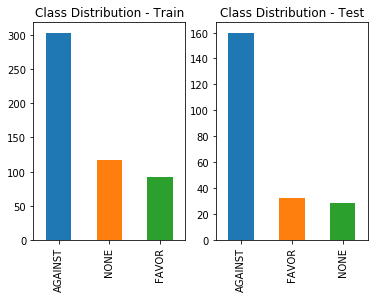

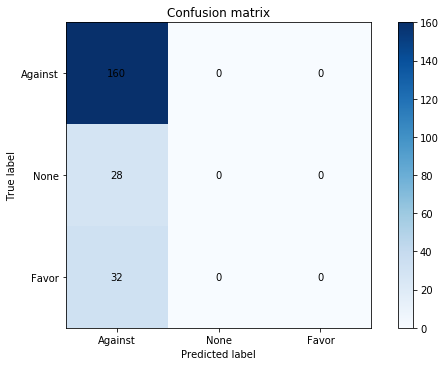

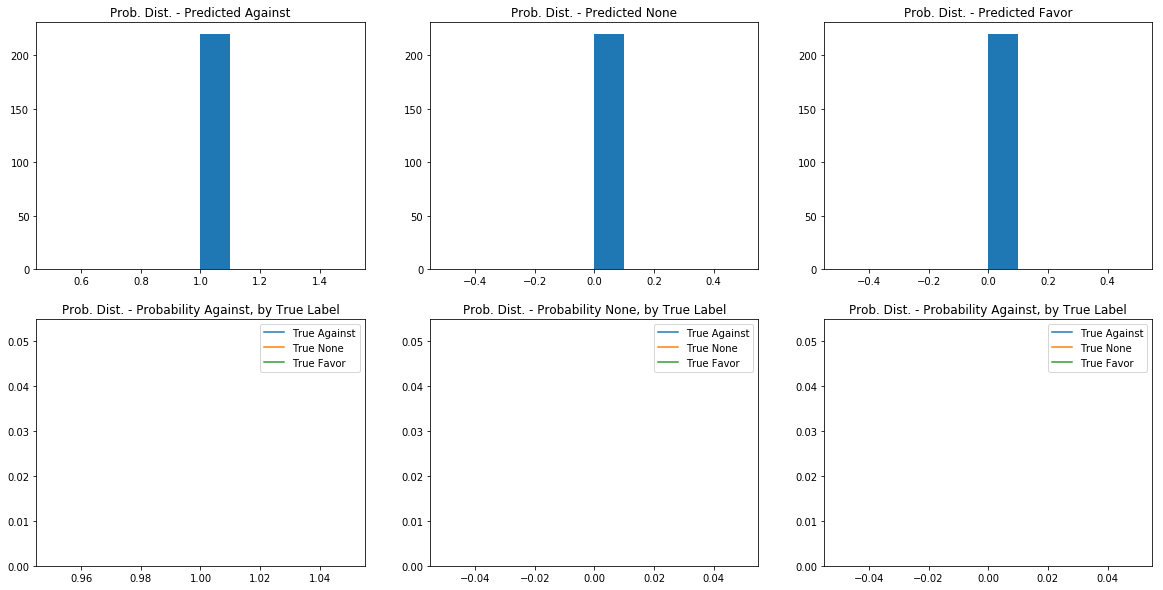

In [51]:
atheism_baseline = baseline_stance(train = twitter_train, 
                                   test = twitter_test, 
                                   topic_in = 'Atheism')
standard_output(model_results = atheism_baseline)

### SVM

In [20]:
def svm_stance(train, test, topic_in):
    # Subset data to topic being tested
    train_topic = train[train['Target'] == topic_in]
    test_topic = test[test['Target'] == topic_in]
    
    #### FEATURES ####
    # Extract tweets
    tweets_train = train_topic['Tweet']
    tweets_test = test_topic['Tweet']

    # Pre-process tweets
    preprocess_train = tweets_train.apply(lambda x: preprocess_tweets(x))
    preprocess_test = tweets_test.apply(lambda x: preprocess_tweets(x))
    
    # Convert training data to sparse matrix 
    # n-gram WORDS
    word_grams = CountVectorizer(ngram_range = (1,3))
    train_nwords = word_grams.fit_transform(preprocess_train)
    test_nwords = word_grams.transform(preprocess_test)
    word_grams_feature_list = word_grams.get_feature_names()
    # n-gram CHARS
    char_grams = CountVectorizer(ngram_range = (2,5), analyzer = 'char')
    train_nchars = char_grams.fit_transform(preprocess_train)
    test_nchars = char_grams.transform(preprocess_test)
    char_grams_feature_list = char_grams.get_feature_names()
    
    # Stack the features
    train_grams = hstack((train_nwords, train_nchars))
    test_grams = hstack((test_nwords, test_nchars))
    full_feature_list = word_grams_feature_list + char_grams_feature_list
       
    #### TARGET ####
    # Convert stance to labels for feeding sklearn SVM
    train_stance_labels = np.array(train_topic['Stance'].apply(lambda x: 
                                                               2 if x == "FAVOR" else 
                                                               (1 if x == "NONE" else 0)))
    test_stance_labels = np.array(test_topic['Stance'].apply(lambda x: 
                                                             2 if x == "FAVOR" else 
                                                             (1 if x == "NONE" else 0)))
  
    #### MODEL ####
    print(topic_in)
    # Train SVM
    start_time_train = time.time()
    svm = SVC(kernel = 'linear', probability = True, class_weight = 'balanced')
    svm.fit(train_grams, train_stance_labels)
    end_time_train = time.time()
    print("Training time:",end_time_train - start_time_train)

    # Prediction
    start_time_predict = time.time()
    test_predict = svm.predict(test_grams)
    test_predict_proba = svm.predict_proba(test_grams)
    end_time_predict = time.time()
    print("Prediction time:", end_time_predict - start_time_predict)

    # Results
    results_dict = {}
    results_dict['model'] = svm
    results_dict['full_feature_list'] = full_feature_list
    results_dict['train_labels'] = train_stance_labels
    results_dict['train_names'] = train_topic['Stance']
    results_dict['test_true_labels'] = test_stance_labels
    results_dict['test_true_names'] = test_topic['Stance']
    results_dict['test_predict'] = test_predict
    results_dict['test_predict_proba'] = test_predict_proba
    results_dict['test_predict_proba_true'] = [item[test_stance_labels[i]] for i, item in enumerate(test_predict_proba)]
    
    return results_dict

Atheism
Training time: 4.741347312927246
Prediction time: 0.4921905994415283
F1 Score: 0.7233705781834979
             precision    recall  f1-score   support

    Against       0.82      0.81      0.82       160
       None       0.46      0.57      0.51        28
      Favor       0.48      0.41      0.44        32

avg / total       0.73      0.72      0.72       220



/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


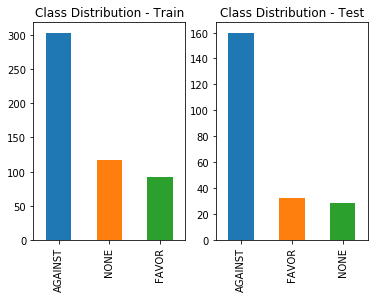

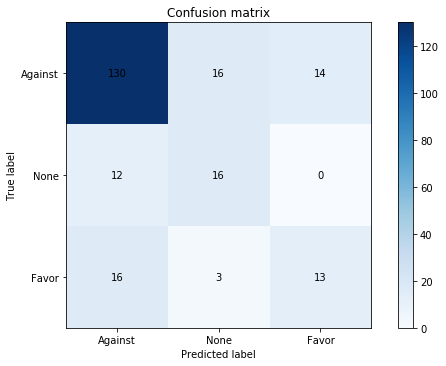

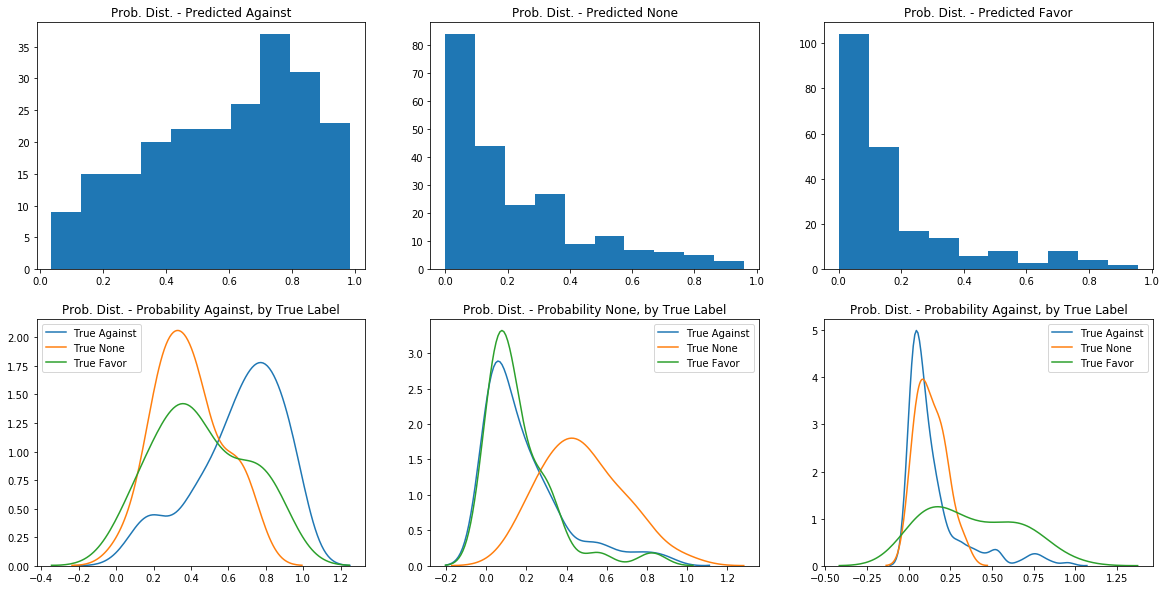

In [52]:
# Atheism
atheism_svm = svm_stance(twitter_train, twitter_test, 'Atheism')
standard_output(model_results = atheism_svm)

Hillary Clinton
Training time: 7.965760946273804
Prediction time: 0.9439098834991455
F1 Score: 0.6900791488873149
             precision    recall  f1-score   support

    Against       0.72      0.83      0.77       172
       None       0.67      0.63      0.65        78
      Favor       0.64      0.36      0.46        45

avg / total       0.70      0.70      0.69       295



/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


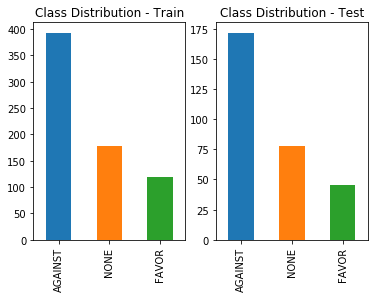

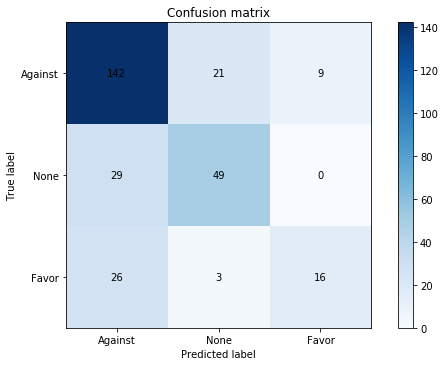

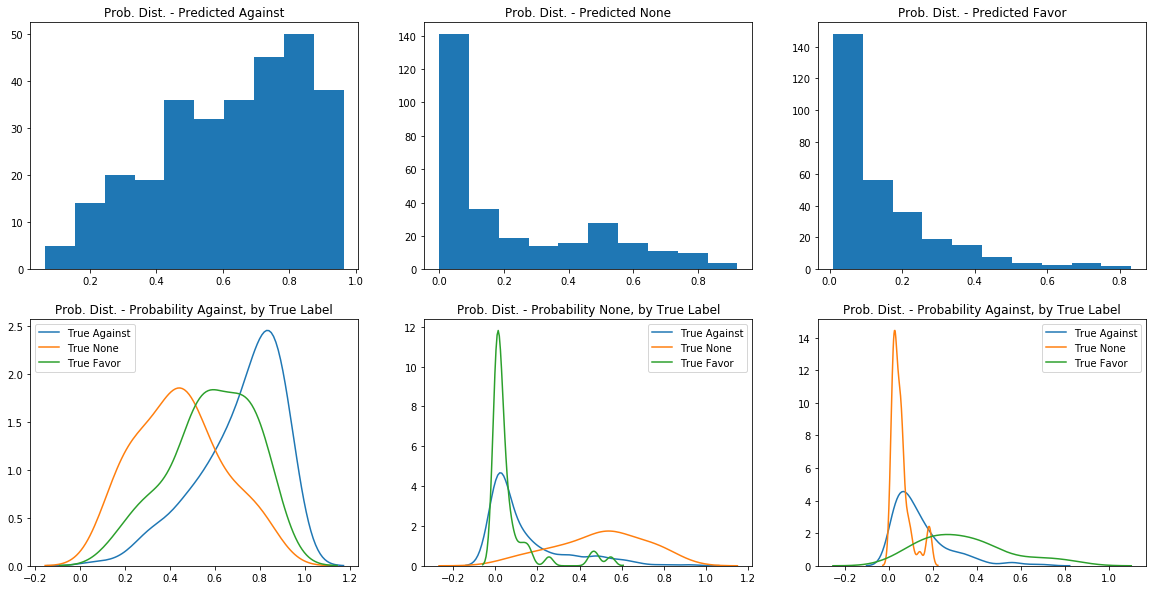

In [53]:
# Hillary Clinton
hillary_svm = svm_stance(twitter_train, twitter_test, 'Hillary Clinton')
standard_output(model_results = hillary_svm)

In [34]:
# Imbalanced classes
from sklearn.utils import resample

# Split out classes
twitter_train_hillary = twitter_train[twitter_train['Target'] == 'Hillary Clinton']
twitter_train_hillary_favor = twitter_train_hillary[twitter_train_hillary['Stance'] == 'FAVOR']
twitter_train_hillary_none = twitter_train_hillary[twitter_train_hillary['Stance'] == 'NONE']
twitter_train_hillary_against = twitter_train_hillary[twitter_train_hillary['Stance'] == 'AGAINST']

twitter_train_hillary_none_upsampled = resample(twitter_train_hillary_none,
                                                replace = True, 
                                                n_samples = twitter_train_hillary_against.shape[0],
                                                random_state = 123)

twitter_train_hillary_favor_upsampled = resample(twitter_train_hillary_favor,
                                                 replace = True, 
                                                 n_samples = twitter_train_hillary_against.shape[0],
                                                 random_state = 123)

twitter_train_hillary_upsampled = pd.concat([twitter_train_hillary_against, 
                                             twitter_train_hillary_none_upsampled,
                                            twitter_train_hillary_favor_upsampled])

print("Against (majority) = " + str(twitter_train_hillary_against.shape))
print("None = " + str(twitter_train_hillary_none.shape))
print("None (upsampled) = " + str(twitter_train_hillary_none_upsampled.shape))
print("Favor (upsampled) = " + str(twitter_train_hillary_favor.shape))
print("Favor (upsampled) = " + str(twitter_train_hillary_favor_upsampled.shape))

Against (majority) = (393, 5)
None = (178, 5)
None (upsampled) = (393, 5)
Favor (upsampled) = (118, 5)
Favor (upsampled) = (393, 5)


Hillary Clinton
Training time: 12.8560209274292
Prediction time: 1.0525383949279785
F1 Score: 0.7084148021721682
             precision    recall  f1-score   support

    Against       0.72      0.87      0.79       172
       None       0.77      0.59      0.67        78
      Favor       0.65      0.38      0.48        45

avg / total       0.72      0.72      0.71       295



/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


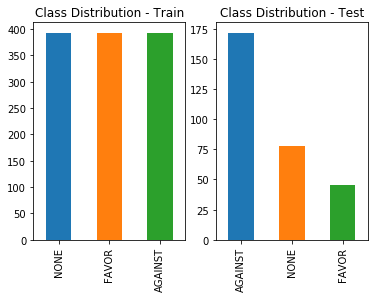

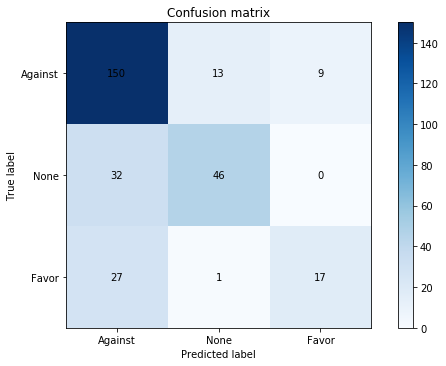

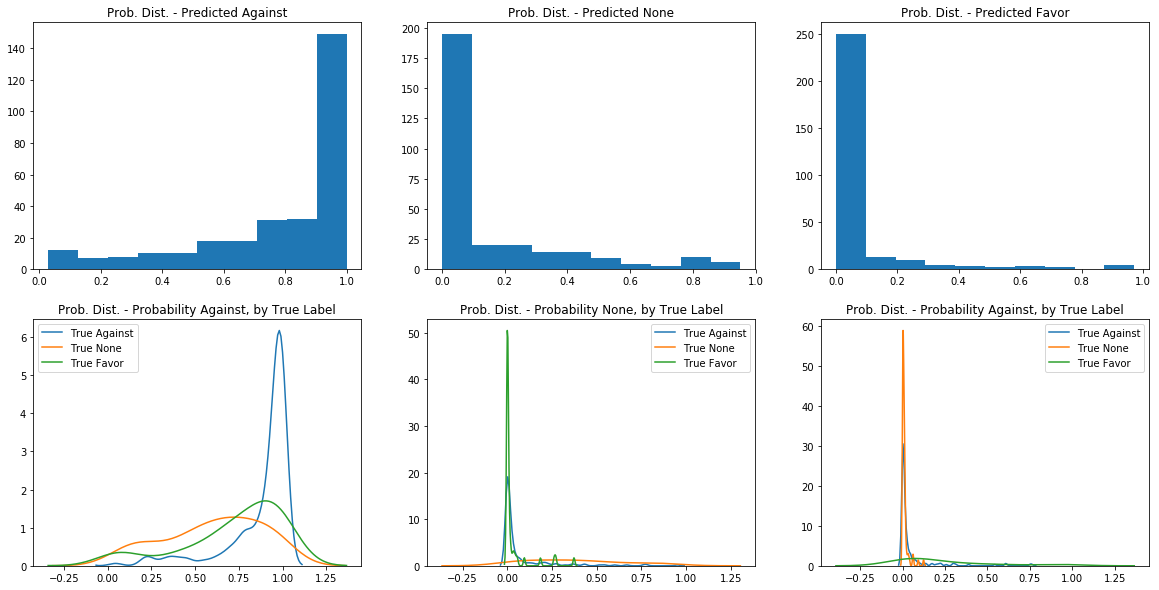

In [54]:
# Hillary Clinton (upsampled)
hillary_svm_upsampled = svm_stance(twitter_train_hillary_upsampled, twitter_test, 'Hillary Clinton')
standard_output(model_results = hillary_svm_upsampled)

Legalization of Abortion
Training time: 7.40519118309021
Prediction time: 0.8274450302124023
F1 Score: 0.5634475771232924
             precision    recall  f1-score   support

    Against       0.80      0.68      0.73       189
       None       0.37      0.58      0.45        45
      Favor       0.50      0.52      0.51        46

avg / total       0.68      0.64      0.65       280



/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


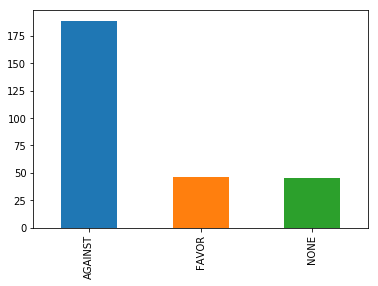

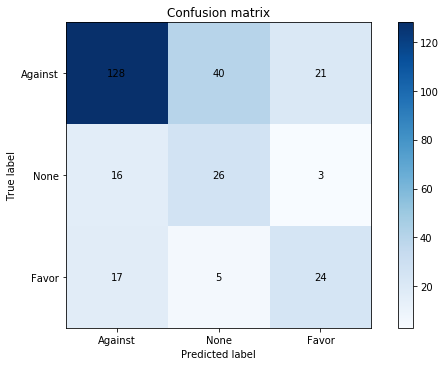

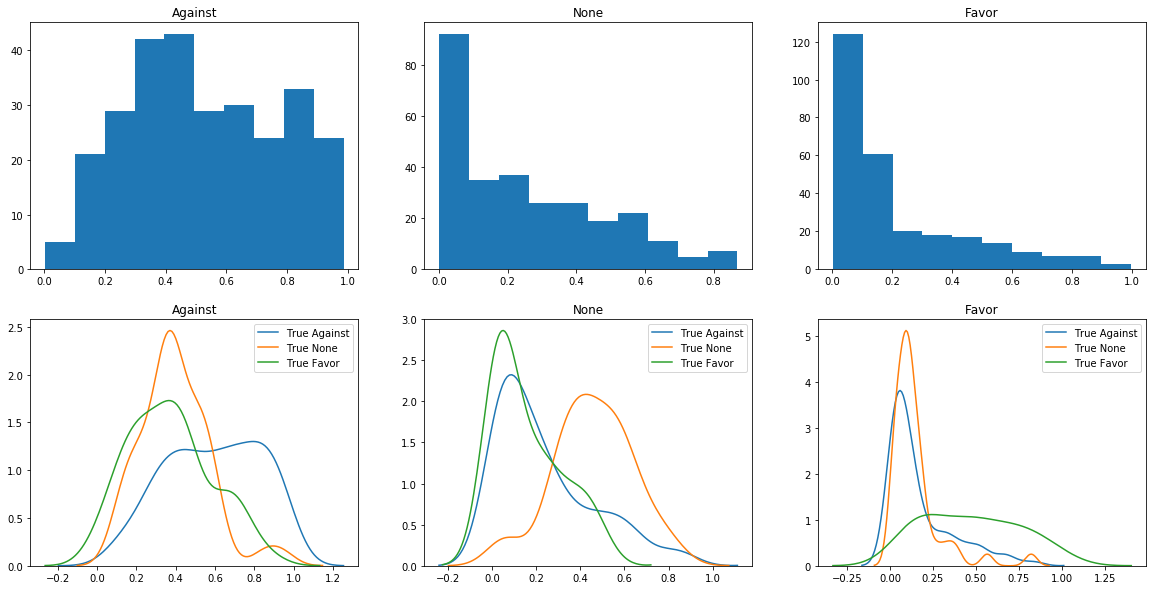

In [332]:
# Legalization of Abortion
abortion_svm = svm_stance(twitter_train, twitter_test, 'Legalization of Abortion')
standard_output(model_results = abortion_svm)

Climate Change is a Real Concern
Training time: 2.8077661991119385
Prediction time: 0.322324275970459
F1 Score: 0.476855927230047
             precision    recall  f1-score   support

    Against       0.00      0.00      0.00        11
       None       0.56      0.57      0.56        35
      Favor       0.83      0.90      0.87       123

avg / total       0.72      0.78      0.75       169



/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


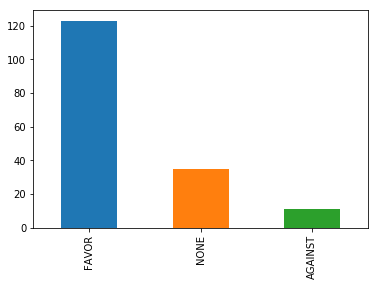

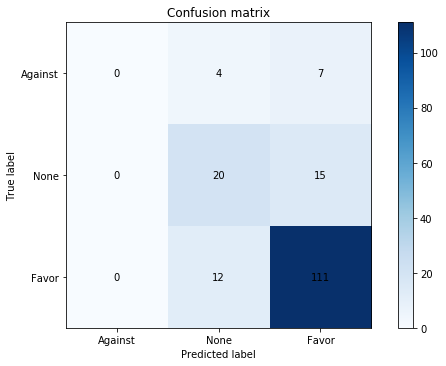

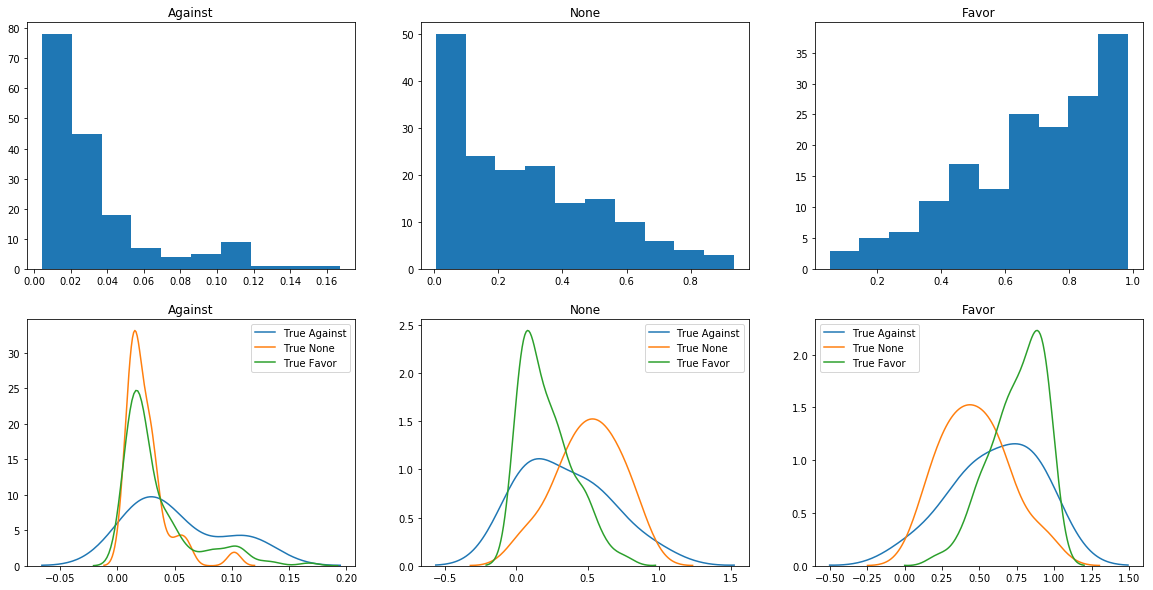

In [333]:
# Climate Change is a Real Concern
climatechange_svm = svm_stance(twitter_train, twitter_test, 'Climate Change is a Real Concern')
standard_output(model_results = climatechange_svm)

Feminist Movement
Training time: 8.163903951644897
Prediction time: 0.9649174213409424
F1 Score: 0.6100954597978991
             precision    recall  f1-score   support

    Against       0.77      0.60      0.68       183
       None       0.47      0.52      0.49        44
      Favor       0.39      0.64      0.49        58

avg / total       0.65      0.60      0.61       285



/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


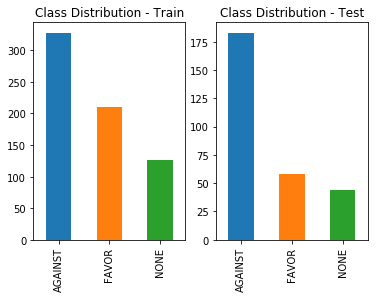

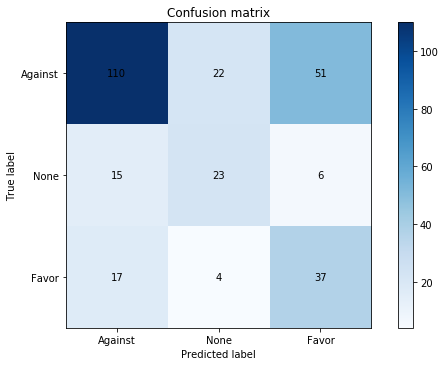

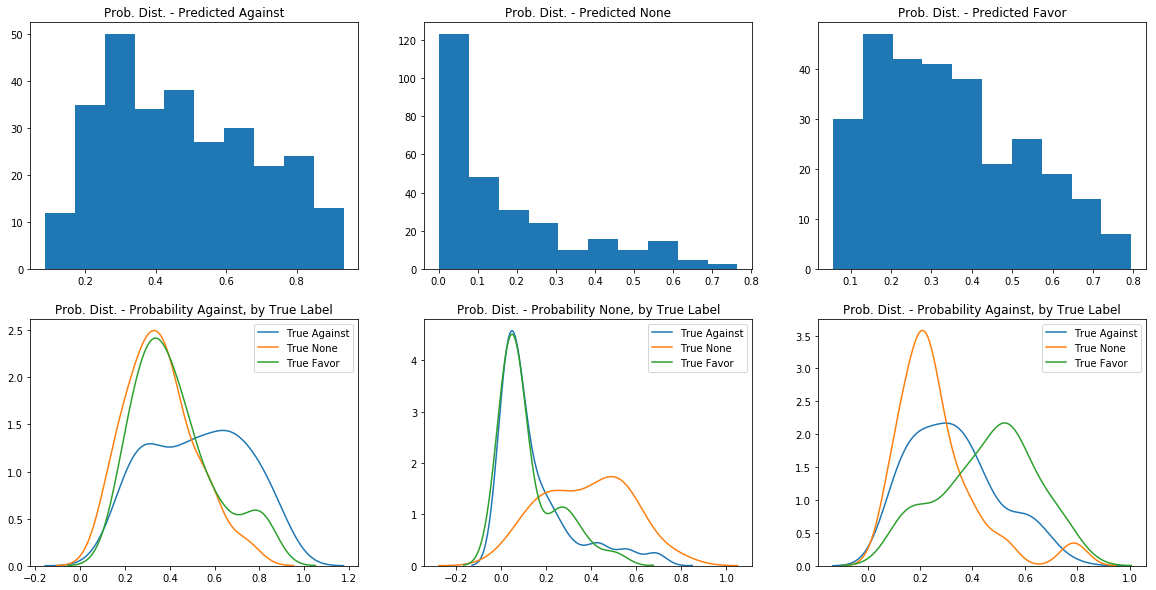

In [63]:
# Feminist Movement
feminist_svm = svm_stance(twitter_train, twitter_test, 'Feminist Movement')
standard_output(model_results = feminist_svm)

### ELMO

In [56]:
def elmo_vectors(x):
    embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return average of ELMo features
        return sess.run(tf.reduce_mean(embeddings,1))

In [57]:
list_train = [twitter_train['Tweet'][i:i+100] for i in range(0,twitter_train['Tweet'].shape[0],100)]
list_test = [twitter_test['Tweet'][i:i+100] for i in range(0,twitter_test['Tweet'].shape[0],100)]

In [61]:
elmo_train = [elmo_vectors(x) for x in list_train]
elmo_test = [elmo_vectors(x) for x in list_test]

NameError: name 'elmo' is not defined

In [361]:
# def svm_elmo(train, test, topic_in):
#     # Subset data to topic being tested
#     train_topic = train[train['Target'] == topic_in]
#     test_topic = test[test['Target'] == topic_in]
    
#     #### FEATURES ####
#     # Extract tweets
#     tweets_train = train_topic['Tweet']
#     tweets_test = test_topic['Tweet']

#     # Pre-process tweets
#     preprocess_train = tweets_train.apply(lambda x: preprocess_tweets(x))
#     preprocess_test = tweets_test.apply(lambda x: preprocess_tweets(x))
    
#     # Convert training data to sparse matrix 
#     # n-gram WORDS
#     word_grams = CountVectorizer(ngram_range = (1,3))
#     train_nwords = word_grams.fit_transform(preprocess_train)
#     test_nwords = word_grams.transform(preprocess_test)
#     word_grams_feature_list = word_grams.get_feature_names()
#     # n-gram CHARS
#     char_grams = CountVectorizer(ngram_range = (2,5), analyzer = 'char')
#     train_nchars = char_grams.fit_transform(preprocess_train)
#     test_nchars = char_grams.transform(preprocess_test)
#     char_grams_feature_list = char_grams.get_feature_names()
    
#     # Stack the features
#     train_grams = hstack((train_nwords, train_nchars))
#     test_grams = hstack((test_nwords, test_nchars))
#     full_feature_list = word_grams_feature_list + char_grams_feature_list
       
#     #### TARGET ####
#     # Convert stance to labels for feeding sklearn SVM
#     train_stance_labels = np.array(train_topic['Stance'].apply(lambda x: 
#                                                                2 if x == "FAVOR" else 
#                                                                (1 if x == "NONE" else 0)))
#     test_stance_labels = np.array(test_topic['Stance'].apply(lambda x: 
#                                                              2 if x == "FAVOR" else 
#                                                              (1 if x == "NONE" else 0)))
  
#     #### MODEL ####
#     print(topic_in)
#     # Train SVM
#     start_time_train = time.time()
#     svm = SVC(kernel = 'linear', probability = True)
#     svm.fit(train_grams, train_stance_labels)
#     end_time_train = time.time()
#     print("Training time:",end_time_train - start_time_train)

#     # Prediction
#     start_time_predict = time.time()
#     test_predict = svm.predict(test_grams)
#     test_predict_proba = svm.predict_proba(test_grams)
#     end_time_predict = time.time()
#     print("Prediction time:", end_time_predict - start_time_predict)

#     # Results
#     results_dict = {}
#     results_dict['model'] = svm
#     results_dict['full_feature_list'] = full_feature_list
#     results_dict['test_true_labels'] = test_stance_labels
#     results_dict['test_true_names'] = test_topic['Stance']
#     results_dict['test_predict'] = test_predict
#     results_dict['test_predict_proba'] = test_predict_proba
#     results_dict['test_predict_proba_true'] = [item[test_stance_labels[i]] for i, item in enumerate(test_predict_proba)]
    
#     return results_dict

## Extra - Features

In [317]:
def top_features_by_label(coef_matrix_in, target_names_in, feature_list_in):
    top_index_lists = []
    top_features_lists = []
    
    # Loop through each label in the coefficient matrix and identify the top 5 features
    for loop_labels in range(coef_matrix_in.shape[0]):
        top_5_index = np.argsort(coef_matrix_in[loop_labels])[::-1][:5]
        top_5_features = [feature_list_in[i] for i in top_5_index]

        top_index_lists.append(top_5_index)
        top_features_lists.append(top_5_features)

    # Flatten feature lists 
    full_top_index_list = [item for sublist in top_index_lists for item in sublist]
    full_top_features_list = [item for sublist in top_features_lists for item in sublist]

    # Creat 20x4 labelled table from coefficeint matrix
    top_20_index = pd.DataFrame(data = coef_matrix_in[:,full_top_index_list].transpose(), \
                                columns = target_names_in, index = full_top_features_list)
    # Plot resulting table
    fig, ax = plt.subplots(figsize = (10,10))
    seaborn.heatmap(top_20_index, annot = True)

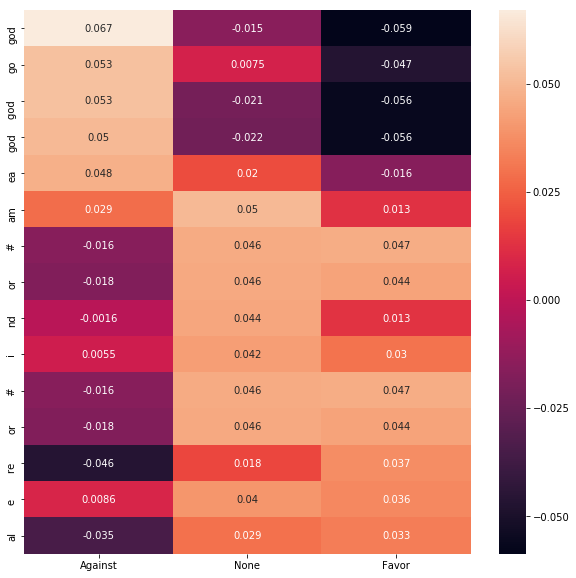

In [318]:
# Top Features
top_features_by_label(coef_matrix_in = atheism_svm['model'].coef_.toarray(), 
                      target_names_in = ['Against', 'None', 'Favor'], 
                      feature_list_in = atheism_svm['full_feature_list'])

In [62]:
# [name for name in atheism_svm['full_feature_list'] if 'god' in name]
# [name for name in atheism_svm['full_feature_list'] if '#' in name]